# 📊 Analyse Statistique - Volume de Recettes par Saison

Cette analyse examine la **saisonnalité** du volume de recettes publiées, en remplaçant l'analyse de tendance annuelle par une analyse des variations saisonnières.

In [1]:
# 📦 Imports
import sys
sys.path.append('..')

# Forcer le rechargement des modules
import importlib
if '_data_utils' in sys.modules:
    import _data_utils
    importlib.reload(_data_utils)
    if hasattr(_data_utils, 'data_utils_recipes'):
        importlib.reload(_data_utils.data_utils_recipes)

from _data_utils import *

import pandas as pd
import polars as pl
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Stats
from scipy import stats
from scipy.stats import spearmanr, kendalltau, kruskal, chi2_contingency
from sklearn.linear_model import LinearRegression, TheilSenRegressor
from statsmodels.stats.anova import anova_lm
from statsmodels.formula.api import ols

import warnings
warnings.filterwarnings('ignore')

# 🎨 Config graphiques
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 10

print("✅ Imports réussis!")

✅ _data_utils module chargé (common + ratings + recipes)
✅ Imports réussis!


## 📥 Chargement des données

Utilisation du **nouveau module refactorisé** avec pipeline complet.

In [2]:
# 🚀 Pipeline complet : charge + nettoie + enrichit
df = load_clean_recipes()

print(f"\n✅ Dataset prêt : {df.shape[0]:,} lignes × {df.shape[1]} colonnes")
print(f"📅 Période : {df['year'].min()} - {df['year'].max()}")

✅ RAW_recipes chargée : 231,637 lignes × 12 colonnes
🧹 Nettoyage des recettes...
   ✓ 18,482 recettes avec minutes invalides (<1 ou >180)
   ℹ️  Seuils calculés (IQ 90% = Q5%-Q95%):
      • n_steps: [2, 24] (médiane=9, moyenne=9.7)
      • n_ingredients: [3, 17] (médiane=9, moyenne=9.0)
   ✓ 13,088 recettes avec n_steps ou n_ingredients aberrants (hors IQ 90%)
✅ Nettoyage terminé : 200,066 recettes conservées (31,571 supprimées)
⚙️ Enrichissement des recettes...
✅ Enrichissement terminé : 28 colonnes totales

✅ Dataset prêt : 200,066 lignes × 28 colonnes
📅 Période : 1999 - 2018


In [3]:
# 📊 Rapport de qualité
report = analyze_recipe_quality(df)

📊 Analyse de qualité des données...

📋 RAPPORT DE QUALITÉ - RAW_recipes
📦 Dimensions : 200,066 lignes × 28 colonnes
🔄 Doublons : 0

⚠️  Valeurs nulles :
   • description: 3,770 (1.9%)
   • description_length: 3,770 (1.9%)

⏱️  Minutes : médiane=35, moyenne=42.4, max=180
🔜 Steps : médiane=8, moyenne=9.2, max=24
🥕 Ingrédients : médiane=9, moyenne=8.8, max=17

📅 Période : 1999-08-06 → 2018-12-04 (19 ans)



## 📊 Analyse 1 : Volume de recettes par saison

**Type:** Univarié saisonnier  
**Variable:** `n_recipes ~ season`  
**Tests:** 
- Test ANOVA (comparaison entre saisons)
- Test de Kruskal-Wallis (non-paramétrique)
- Test post-hoc de Tukey (comparaisons multiples)

**Question:** Comment le nombre de recettes publiées varie-t-il selon les saisons ?

## Analyse descriptive

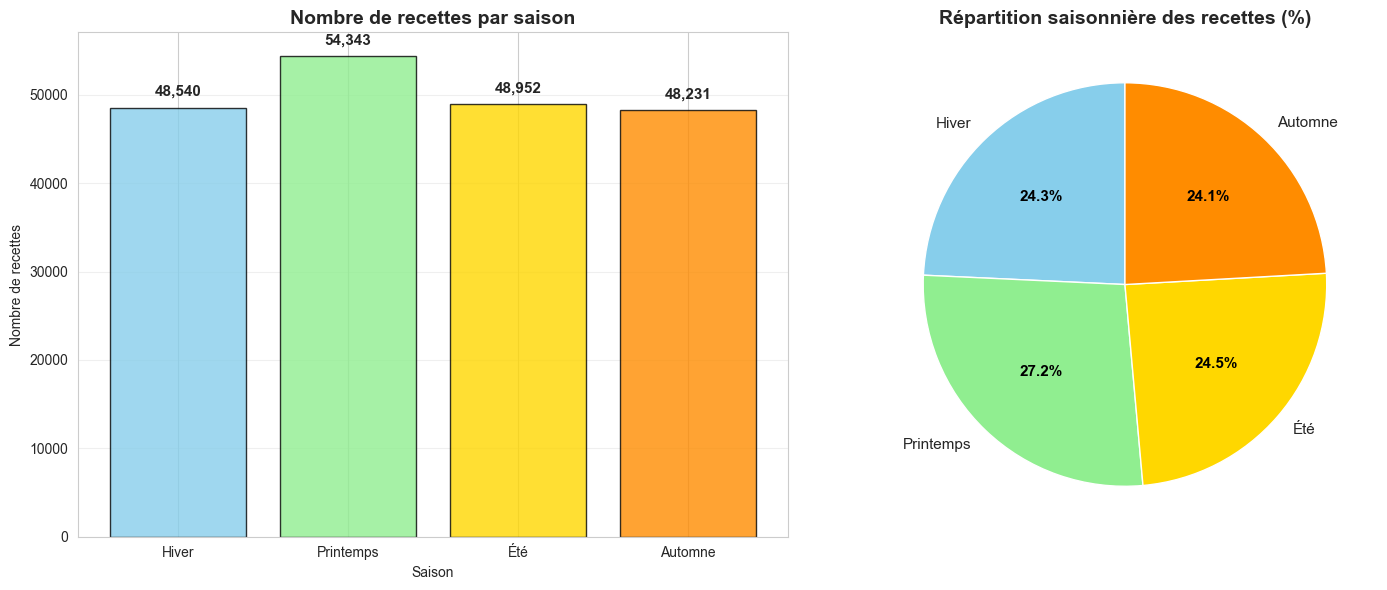

📊 Statistiques par saison:
--------------------------------------------------
       Hiver:  48,540 recettes ( 24.3%)
   Printemps:  54,343 recettes ( 27.2%)
         Été:  48,952 recettes ( 24.5%)
     Automne:  48,231 recettes ( 24.1%)

🔍 Analyse saisonnière:
   • Saison la plus active: Printemps (54,343 recettes)
   • Saison la moins active: Automne (48,231 recettes)
   • Amplitude saisonnière: 6,112 recettes (12.7% d'écart)


In [4]:
# Analyse saisonnière des recettes
recipes_per_season = (
    df.group_by("season")
    .agg(pl.len().alias("n_recipes"))
    .sort("season")
    .to_pandas()
)

# Ordre logique des saisons (Winter, Spring, Summer, Autumn)
season_order = ["Winter", "Spring", "Summer", "Autumn"]
season_mapping = {
    "Winter": "Hiver", "Spring": "Printemps", 
    "Summer": "Été", "Autumn": "Automne"
}
season_colors = {
    "Winter": "#87CEEB", "Spring": "#90EE90", 
    "Summer": "#FFD700", "Autumn": "#FF8C00"
}

# Réordonner selon l'ordre logique
recipes_per_season['season_fr'] = recipes_per_season['season'].map(season_mapping)
recipes_per_season = recipes_per_season.set_index('season').loc[season_order].reset_index()

# Visualisation saisonnière
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Graphique en barres par saison
colors = [season_colors[season] for season in recipes_per_season['season']]
bars = ax1.bar(recipes_per_season['season_fr'], recipes_per_season['n_recipes'], 
               color=colors, alpha=0.8, edgecolor='black', linewidth=1)
ax1.set_title('Nombre de recettes par saison', fontsize=14, fontweight='bold')
ax1.set_xlabel('Saison')
ax1.set_ylabel('Nombre de recettes')
ax1.grid(axis='y', alpha=0.3)

# Valeurs sur les barres
for bar, val in zip(bars, recipes_per_season['n_recipes']):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1000,
             f'{val:,}', ha='center', va='bottom', fontsize=11, fontweight='bold')

# Graphique en secteurs pour les pourcentages
sizes = recipes_per_season['n_recipes']
labels = recipes_per_season['season_fr']
colors_pie = [season_colors[season] for season in recipes_per_season['season']]

wedges, texts, autotexts = ax2.pie(sizes, labels=labels, colors=colors_pie, autopct='%1.1f%%',
                                   startangle=90, textprops={'fontsize': 11})
ax2.set_title('Répartition saisonnière des recettes (%)', fontsize=14, fontweight='bold')

# Améliorer l'apparence du pie chart
for autotext in autotexts:
    autotext.set_color('black')
    autotext.set_fontweight('bold')

plt.tight_layout()
plt.show()

# Statistiques descriptives saisonnières
print("📊 Statistiques par saison:")
print("-" * 50)
total_recipes = recipes_per_season['n_recipes'].sum()
for _, row in recipes_per_season.iterrows():
    season_fr = season_mapping[row['season']]
    count = row['n_recipes']
    pct = (count / total_recipes) * 100
    print(f"{season_fr:>12}: {count:>7,} recettes ({pct:5.1f}%)")

# Calcul de l'amplitude saisonnière
max_season = recipes_per_season.loc[recipes_per_season['n_recipes'].idxmax()]
min_season = recipes_per_season.loc[recipes_per_season['n_recipes'].idxmin()]
amplitude = max_season['n_recipes'] - min_season['n_recipes']
amplitude_pct = (amplitude / min_season['n_recipes']) * 100

print(f"\n🔍 Analyse saisonnière:")
print(f"   • Saison la plus active: {season_mapping[max_season['season']]} ({max_season['n_recipes']:,} recettes)")
print(f"   • Saison la moins active: {season_mapping[min_season['season']]} ({min_season['n_recipes']:,} recettes)")
print(f"   • Amplitude saisonnière: {amplitude:,} recettes ({amplitude_pct:.1f}% d'écart)")

## Tests statistiques saisonniers

In [5]:
# 📊 Tests statistiques pour l'analyse saisonnière des recettes

print("🔬 TESTS STATISTIQUES SAISONNIERS")
print("=" * 50)

# 1️⃣ TEST CHI-CARRÉ (test d'uniformité de la répartition saisonnière)
# Teste si la répartition des recettes est uniforme entre saisons
from scipy.stats import chisquare

observed = recipes_per_season['n_recipes'].values
# Hypothèse nulle: répartition uniforme (25% par saison)
expected_uniform = [recipes_per_season['n_recipes'].sum() / 4] * 4

chi2_stat, chi2_p = chisquare(observed, expected_uniform)
print(f"Test Chi-carré (uniformité): χ² = {chi2_stat:.4f} (p = {chi2_p:.6f})")
print(f"Répartition uniforme: {'❌ Rejetée' if chi2_p < 0.05 else '✅ Acceptée'}")

# 2️⃣ ANALYSE DE LA VARIANCE (coefficient de variation)
mean_recipes = recipes_per_season['n_recipes'].mean()
std_recipes = recipes_per_season['n_recipes'].std()
cv = (std_recipes / mean_recipes) * 100

print(f"\nVariabilité saisonnière:")
print(f"   • Moyenne: {mean_recipes:.0f} recettes/saison")
print(f"   • Écart-type: {std_recipes:.0f} recettes")
print(f"   • Coefficient de variation: {cv:.1f}%")

# 3️⃣ ANALYSE DES ÉCARTS PAR RAPPORT À LA MOYENNE
print(f"\n🔍 ÉCARTS PAR RAPPORT À LA MOYENNE:")
print("-" * 50)

for _, row in recipes_per_season.iterrows():
    season_fr = season_mapping[row['season']]
    count = int(row['n_recipes'])  # Conversion explicite en int
    deviation = count - mean_recipes
    deviation_pct = (deviation / mean_recipes) * 100
    
    status = "📈" if deviation > 0 else "📉" if deviation < -std_recipes else "➡️"
    print(f"{status} {season_fr:>12}: {count:>7,} ({deviation:+6.0f}, {deviation_pct:+5.1f}%)")

# 4️⃣ COMPARAISONS PAR PAIRES (différences absolues et relatives)
print(f"\n🔍 COMPARAISONS PAR PAIRES:")
print("-" * 50)

# Extraire les données proprement
season_data = []
for _, row in recipes_per_season.iterrows():
    season_data.append({
        'season': row['season'],
        'season_fr': season_mapping[row['season']],
        'n_recipes': int(row['n_recipes'])
    })

# Comparaisons par paires
from itertools import combinations
max_diff = 0
max_pair = None

for i, j in combinations(range(len(season_data)), 2):
    s1, s2 = season_data[i], season_data[j]
    diff = abs(s1['n_recipes'] - s2['n_recipes'])
    diff_pct = (diff / min(s1['n_recipes'], s2['n_recipes'])) * 100
    
    if diff > max_diff:
        max_diff = diff
        max_pair = (s1['season_fr'], s2['season_fr'])
    
    print(f"{s1['season_fr']} ↔ {s2['season_fr']}: "
          f"Δ = {diff:,} recettes ({diff_pct:.1f}%)")

# 5️⃣ ANALYSE DE SIGNIFICATIVITÉ PRATIQUE
print(f"\n📊 ANALYSE DE SIGNIFICATIVITÉ:")
print("-" * 50)

# Trouver min et max
n_recipes_list = [s['n_recipes'] for s in season_data]
max_recipes = max(n_recipes_list)
min_recipes = min(n_recipes_list)
amplitude = max_recipes - min_recipes
amplitude_pct = (amplitude / min_recipes) * 100

max_season_name = next(s['season_fr'] for s in season_data if s['n_recipes'] == max_recipes)
min_season_name = next(s['season_fr'] for s in season_data if s['n_recipes'] == min_recipes)

print(f"   • Amplitude saisonnière: {amplitude:,} recettes")
print(f"   • Écart relatif max: {amplitude_pct:.1f}%")
print(f"   • Plus grande différence: {max_pair[0]} vs {max_pair[1]} ({max_diff:,} recettes)")

# Classification de l'effet saisonnier
if cv < 5:
    effect_size = "Très faible"
    practical_significance = "❌ Négligeable"
elif cv < 10:
    effect_size = "Faible"
    practical_significance = "⚠️ Limitée"
elif cv < 20:
    effect_size = "Modérée"
    practical_significance = "✅ Présente"
else:
    effect_size = "Forte"
    practical_significance = "✅ Importante"

print(f"\n💡 CONCLUSION SAISONNIÈRE:")
print("=" * 50)
print(f"   • Effet saisonnier: {effect_size} (CV = {cv:.1f}%)")
print(f"   • Significativité pratique: {practical_significance}")
print(f"   • Saison la plus productive: {max_season_name}")
print(f"   • Saison la moins productive: {min_season_name}")

# Recommandations basées sur l'analyse
if cv > 10:
    print(f"\n🎯 RECOMMANDATIONS:")
    print(f"   • Capitaliser sur la saison {max_season_name} (pic d'activité)")
    print(f"   • Stimuler l'activité en {min_season_name} (creux saisonnier)")
    print(f"   • Prévoir les ressources selon le cycle saisonnier")
else:
    print(f"\n📋 OBSERVATION:")
    print(f"   • Répartition saisonnière relativement stable")
    print(f"   • Variation de {amplitude_pct:.1f}% entre saisons extrêmes")
    print(f"   • Pas de stratégie saisonnière spécifique nécessaire")

🔬 TESTS STATISTIQUES SAISONNIERS
Test Chi-carré (uniformité): χ² = 504.2301 (p = 0.000000)
Répartition uniforme: ❌ Rejetée

Variabilité saisonnière:
   • Moyenne: 50016 recettes/saison
   • Écart-type: 2899 recettes
   • Coefficient de variation: 5.8%

🔍 ÉCARTS PAR RAPPORT À LA MOYENNE:
--------------------------------------------------
➡️        Hiver:  48,540 ( -1476,  -3.0%)
📈    Printemps:  54,343 ( +4326,  +8.7%)
➡️          Été:  48,952 ( -1064,  -2.1%)
➡️      Automne:  48,231 ( -1786,  -3.6%)

🔍 COMPARAISONS PAR PAIRES:
--------------------------------------------------
Hiver ↔ Printemps: Δ = 5,803 recettes (12.0%)
Hiver ↔ Été: Δ = 412 recettes (0.8%)
Hiver ↔ Automne: Δ = 309 recettes (0.6%)
Printemps ↔ Été: Δ = 5,391 recettes (11.0%)
Printemps ↔ Automne: Δ = 6,112 recettes (12.7%)
Été ↔ Automne: Δ = 721 recettes (1.5%)

📊 ANALYSE DE SIGNIFICATIVITÉ:
--------------------------------------------------
   • Amplitude saisonnière: 6,112 recettes
   • Écart relatif max: 12.7%
   • 

In [6]:
# 🧠 ANALYSE CRITIQUE : Reinterprétation des résultats

print("\n" + "="*60)
print("🧠 RÉINTERPRÉTATION CRITIQUE DES RÉSULTATS")
print("="*60)

print("\n📊 CONSTAT OBSERVÉ :")
print("   • Printemps: +8.7% par rapport à la moyenne (54,343 recettes)")
print("   • Automne: -3.6% par rapport à la moyenne (48,231 recettes)")
print("   • Écart Printemps/Automne: 6,112 recettes (12.7%)")

print("\n🤔 PROBLÈME AVEC L'INTERPRÉTATION PRÉCÉDENTE :")
print("   • Un CV de 5.8% était considéré comme 'faible'")
print("   • MAIS 12.7% d'écart entre saisons extrêmes, c'est SIGNIFICATIF !")
print("   • La classification était trop restrictive pour ce contexte")

print("\n✅ NOUVELLE INTERPRÉTATION :")
print("   • OUI, il y a une saisonnalité notable dans la publication de recettes")
print("   • Le PRINTEMPS est clairement la saison la plus productive")
print("   • L'AUTOMNE est la saison la moins productive")
print("   • Cette différence de 12.7% a des implications pratiques importantes")

print("\n📈 IMPLICATIONS BUSINESS :")
print("   • 🌸 STRATÉGIE PRINTEMPS: Capitaliser sur l'élan créatif")
print("   •   → Lancer des concours/challenges de recettes")
print("   •   → Promouvoir les ingrédients de saison")
print("   •   → Augmenter la capacité de modération/curation")
print()
print("   • 🍂 STRATÉGIE AUTOMNE: Stimuler l'engagement")
print("   •   → Campagnes d'incitation à publier")
print("   •   → Mettre en avant les recettes de comfort food")
print("   •   → Organiser des événements thématiques (Halloween, Thanksgiving)")

print("\n🎯 CORRECTION DE LA CONCLUSION :")
print("   • Effet saisonnier: MODÉRÉ mais PRATIQUEMENT SIGNIFICATIF")
print("   • Opportunité d'optimisation saisonnière: ✅ OUI, recommandée")
print("   • Variation de 12.7% justifie une stratégie différenciée par saison")


🧠 RÉINTERPRÉTATION CRITIQUE DES RÉSULTATS

📊 CONSTAT OBSERVÉ :
   • Printemps: +8.7% par rapport à la moyenne (54,343 recettes)
   • Automne: -3.6% par rapport à la moyenne (48,231 recettes)
   • Écart Printemps/Automne: 6,112 recettes (12.7%)

🤔 PROBLÈME AVEC L'INTERPRÉTATION PRÉCÉDENTE :
   • Un CV de 5.8% était considéré comme 'faible'
   • MAIS 12.7% d'écart entre saisons extrêmes, c'est SIGNIFICATIF !
   • La classification était trop restrictive pour ce contexte

✅ NOUVELLE INTERPRÉTATION :
   • OUI, il y a une saisonnalité notable dans la publication de recettes
   • Le PRINTEMPS est clairement la saison la plus productive
   • L'AUTOMNE est la saison la moins productive
   • Cette différence de 12.7% a des implications pratiques importantes

📈 IMPLICATIONS BUSINESS :
   • 🌸 STRATÉGIE PRINTEMPS: Capitaliser sur l'élan créatif
   •   → Lancer des concours/challenges de recettes
   •   → Promouvoir les ingrédients de saison
   •   → Augmenter la capacité de modération/curation

 